In [510]:
import sys
sys.path.append("/Users/rohanramesh/Documents/GitHub/Basketball_predictions/lib/")
import requests
from bs4 import BeautifulSoup
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import stats
import pickle

In [66]:
# Going to be taking the data for yearly stats from basketball reference.com
years_to_grab = range(2008,2019)

html_format = 'https://www.basketball-reference.com/leagues/NBA_2012_per_game.html'
advanced_stats = 'https://www.basketball-reference.com/leagues/NBA_2012_advanced.html'
per_100_pos = 'https://www.basketball-reference.com/leagues/NBA_2012_per_poss.html'
# yearly_rankings = 'https://www.basketball-reference.com/leagues/NBA_2012_standings.html#all_expanded_standings'


# iterate through each year
all_soups = {}
all_adv_soups = {}
all_100pos_soups = {}
for curr_year in years_to_grab:
    # to iterate through each year just replace the year from above
    curr_html = html_format.replace("2012", str(curr_year))
    curr_html_advance = advanced_stats.replace("2012", str(curr_year))
    curr_html_100pos = per_100_pos.replace("2012", str(curr_year))
    # get data from proper page  and store in all_soups
    page = requests.get(curr_html)
    all_soups[str(curr_year)] = BeautifulSoup(page.text,'lxml')
    page_adv = requests.get(curr_html_advance)
    all_adv_soups[str(curr_year)] = BeautifulSoup(page_adv.text,'lxml')
    page_100pos = requests.get(curr_html_100pos)
    all_100pos_soups[str(curr_year)] = BeautifulSoup(page_100pos.text,'lxml')    
 

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [30]:
# For each year lets extract the data and respective headers
from get_player_team_data import get_data_table
yearly_data = {}
yearly_data_adv = {}
yearly_data_100pos = {}
yearly_headers = {}
yearly_headers_adv = {}
yearly_headers_100pos = {}
for curr_year in years_to_grab:
    (yearly_data[str(curr_year)],headers) = get_data_table(all_soups[str(curr_year)])
    (yearly_data_adv[str(curr_year)],headers_adv) = get_data_table(all_adv_soups[str(curr_year)])
    (yearly_data_100pos[str(curr_year)],headers_100pos) = get_data_table(all_100pos_soups[str(curr_year)])
    # remove the ranking label bc meaningless
    headers.remove('Rk')
    headers_adv.remove('Rk')
    headers_100pos.remove('Rk')
    yearly_headers[str(curr_year)] = headers
    yearly_headers_adv[str(curr_year)] = headers_adv
    yearly_headers_100pos[str(curr_year)] = headers_100pos

In [172]:
# all helper functions for this script
# quickly test if value is a float
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# get all data from a table from a basketball reference page
def get_data_table(soup):
    data = []
    headers = []
    # get every table
    table = soup.find('table')
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    nRows = len(rows)
    # to actually extract the data for each year
    for curr_row in rows:
        all_col_that_row = curr_row.find_all('td')
        if len(all_col_that_row) > 0:
            data_curr_row = []
            for curr_col in all_col_that_row:
                # if isnumeric convert to float for later math
                if isfloat(curr_col.text):
                    data_curr_row.append(float(curr_col.text))
                else:
                    data_curr_row.append(curr_col.text)      
            data.append(data_curr_row)
    table_head = table.find('thead')
    table_head_row = table_head.find('tr')
    th_col = table_head_row.find_all('th')
    for curr_head in th_col:
        headers.append(curr_head.text)
    return (data, headers)

            
# make a function that quickly will give you all values in a column that you care about
# assumes that the length of the headers label matches the number of columns in the dataset
def get_stats_player(dataset,headers,year,stat="all",name="all",pos='all'):
    if isinstance(year,str):
        curr_data = dataset[year]
        curr_headers = headers[year]
    else:
        curr_data = dataset[str(year)]
        curr_headers = headers[str(year)]
    # if want all stats see what that should be
    if stat == "all":
        stat = [curr_headers[i] for i in range(0,len(curr_data[0])) if isfloat(curr_data[0][i])]
    # check if type of data is a list and if not make it one
    if isinstance(stat, list) == False:
        stat = [stat]
    # these are the columns to use based off the stats selected
    col_to_use = []
    for curr_category in stat:
        col_to_use.append(curr_headers.index(curr_category))
    # for indexing purposes lets grab all of the names and all of the positions
    all_names =[]
    all_pos = []
    all_teams = []
    for curr_row in range(0,np.shape(curr_data)[0]):
        if "Player" in curr_headers:
            # get all the names
            all_names.append(curr_data[curr_row][curr_headers.index("Player")])
            # get all the positions
            all_pos.append(curr_data[curr_row][curr_headers.index("Pos")])
        # bc team exists in all dicts
        all_teams.append(curr_data[curr_row][curr_headers.index("Tm")])
    # if gave stat as player or pos then just give this vector output
    # weird way to use the function and not recommended
    if stat == ['Player']:
        final_output = [all_names]
        return final_output
    elif stat == ['Pos']:
        final_output = [all_pos]
        return final_output
    elif stat == ['Tm']:
        final_output = [all_teams]
        return final_output
    # now grab that col of the dataset for those players you want
    data_for_relevant_col = []
    for curr_col in col_to_use:
        curr_vec = []
        for curr_row in range(0,np.shape(curr_data)[0]):
            #dealing with empty data bc didn't attempt something so making 0 if empty
            if isfloat(curr_data[curr_row][curr_col]):
                curr_vec.append(curr_data[curr_row][curr_col])
            else:
                curr_vec.append(0)
        data_for_relevant_col.append(curr_vec)
    # assuming you will either sort by name or position
    if name!= "all":
        final_output = []
        for curr_cat in range(0,np.shape(data_for_relevant_col)[0]):
            final_output.append(data_for_relevant_col[curr_cat][all_names.index(name)])
    elif pos!= "all":
        # this is the index of all rows with this position
        idx = [curr_pos for curr_pos in range(0,len(all_pos)) if pos in all_pos[curr_pos]]
        final_output = []
        for curr_cat in range(0,np.shape(data_for_relevant_col)[0]):
            for curr_idx in idx:
                final_output.append(data_for_relevant_col[curr_cat][curr_idx]) 
    else:
        final_output = data_for_relevant_col
    return final_output


In [227]:
# lets get the data from a page listing the ppg for and ppg against
scoring_page = 'https://www.foxsports.com/nba/team-stats?season=2012&category=SCORING&group=1&time=0'
shooting_page = 'https://www.foxsports.com/nba/team-stats?season=2018&category=SHOOTING&group=1&time=0'
assists_page = 'https://www.foxsports.com/nba/team-stats?season=2018&category=ASSISTS&group=1&time=0'
wins_page = 'https://www.foxsports.com/nba/standings?season=2017&seasonType=1&grouping=3&advanced=0'

# iterate through each year
all_scoring_soups = {}
all_shooting_soups = {}
all_ast_soups = {}
all_wins_soups = {}
for curr_year in years_to_grab:
    # to iterate through each year just replace the year from above
    curr_html = scoring_page.replace("2012", str(curr_year))
    curr_shoot = shooting_page.replace("2018", str(curr_year))
    curr_ast = assists_page.replace("2018", str(curr_year))
    curr_wins = wins_page.replace("2017", str(curr_year-1))
    # get data from proper page  and store in all_soups
    page = requests.get(curr_html)
    all_scoring_soups[str(curr_year)] = BeautifulSoup(page.text,'lxml')
    page = requests.get(curr_shoot)
    all_shooting_soups[str(curr_year)] = BeautifulSoup(page.text,'lxml')
    page = requests.get(curr_ast)
    all_ast_soups[str(curr_year)] = BeautifulSoup(page.text,'lxml')
    page = requests.get(curr_wins)
    all_wins_soups[str(curr_year)] = BeautifulSoup(page.text,'lxml')

In [496]:
def get_yearly_data_foxsports(curr_soup,wins_tag=False):
    """ parse foxsports data - bc the wins page is different parsing that differently"""
    (a,curr_headers) = get_data_table(curr_soup)
    # reformat header and output variable bc doing weird stuff with strings
    curr_headers = [i.rstrip().lstrip() for i in curr_headers]
    curr_headers.remove(curr_headers[0]) # this rank isn't usefule will recreate later
    curr_headers.insert(0,'Tm') # put in tm name
    for curr_row in range(0,np.shape(a)[0]):
        # remove formatting for the team name and remove the Scoring rank
        if wins_tag == False:
            nremove = [int(s) for s in re.findall(r'\d+', a[curr_row][0])]
            new_row = [a[curr_row][i].lstrip(("\n\n%f\n\n" % (nremove[0]))).rstrip()  
                     for i in range(0,len(a[curr_row])) if (isinstance(a[curr_row][i],str)) & (curr_headers[i] == 'Tm')]
            new_row[0] = new_row[0].replace('\n',' ')
            a[curr_row][0] = new_row[0]
        elif wins_tag == True:
            b = [a[curr_row][0].lstrip()]
            c = b[0].find("\n\n")
            d = [b[0][0:c]]
            a[curr_row][0] = d[0].replace('\n', ' ')
    return a, curr_headers


def reorder_team_df_and_combine(all_df, tags):
    teams = all_df[0]['Tm'].tolist()
    for i in range(1,len(all_df)):
        teams_according_to_curr_df = all_df[i]['Tm'].tolist()
        A = all_df[i]
        idx = [teams_according_to_curr_df.index(curr_team) for curr_team in teams]
        A = A.reindex(idx)
        all_df[i] = A
    new_dict = {}
    new_dict['Tm'] = teams
    for i in range(0,len(all_df)):
        header_that_df = list(all_df[i])
        # now iterate through all columns for that df and take column with those players
        numeric_headers = [list(all_df[i])[j] for j 
                   in range(0,len(header_that_df)) if isfloat(all_df[i].iloc[0,j])]
        for curr_header in numeric_headers:
            if curr_header in new_dict:
                new_dict[curr_header+tags[i]] = all_df[i][curr_header].tolist()
            else:
                new_dict[curr_header] = all_df[i][curr_header].tolist()
    new_df = pd.DataFrame.from_dict(new_dict)
    return new_df



In [497]:
from get_player_team_data import get_yearly_data_foxsports
# get the data from the foxsports websites and put into a dict for each year
yearly_scoring_data = {}
yearly_scoring_headers = {}
yearly_shooting_data = {}
yearly_shooting_headers = {}
yearly_ast_data = {}
yearly_ast_headers = {}
yearly_wins_data = {}
yearly_wins_headers = {}
for curr_year in years_to_grab:
    # for scoring
    [a, curr_headers] = get_yearly_data_foxsports(all_scoring_soups[str(curr_year)])
    yearly_scoring_data[str(curr_year)] = a
    yearly_scoring_headers[str(curr_year)] = curr_headers
    # for shooting
    [a, curr_headers] = get_yearly_data_foxsports(all_shooting_soups[str(curr_year)])
    yearly_shooting_data[str(curr_year)] = a
    yearly_shooting_headers[str(curr_year)] = curr_headers
    # for assists
    [a, curr_headers] = get_yearly_data_foxsports(all_ast_soups[str(curr_year)])
    yearly_ast_data[str(curr_year)] = a
    yearly_ast_headers[str(curr_year)] = curr_headers
    # for wins
    [a, curr_headers] = get_yearly_data_foxsports(all_wins_soups[str(curr_year)],wins_tag=True)
    yearly_wins_data[str(curr_year)] = a
    yearly_wins_headers[str(curr_year)] = curr_headers

In [498]:
# lets build the DataFrame - one for each year - had to do this way because of formatting of table
# first lets build giant dict with data from that year
from get_player_team_data import get_stats_player
Yearly_df_team_shooting = {}
Yearly_df_team_scoring = {}
Yearly_df_team_ast = {}
Yearly_df_team_wins = {}
for curr_year in years_to_grab:
    print(curr_year)
    curr_dict_scoring = {}
    curr_dict_shooting = {}
    curr_dict_ast = {}
    curr_dict_wins = {}
    # add in scoring, shooting, ast, and wins data
    for curr_header in yearly_scoring_headers[str(curr_year)]:
        A = get_stats_player(yearly_scoring_data,yearly_scoring_headers,curr_year,stat=curr_header)
        curr_dict_scoring[curr_header] = A[0]
    for curr_header in yearly_shooting_headers[str(curr_year)]:
        A = get_stats_player(yearly_shooting_data,yearly_shooting_headers,curr_year,stat=curr_header)
        curr_dict_shooting[curr_header] = A[0]
    for curr_header in yearly_ast_headers[str(curr_year)]:
        A = get_stats_player(yearly_ast_data,yearly_ast_headers,curr_year,stat=curr_header)
        curr_dict_ast[curr_header] = A[0]
    for curr_header in yearly_wins_headers[str(curr_year)]:
        A = get_stats_player(yearly_wins_data,yearly_wins_headers,curr_year,stat=curr_header)
        curr_dict_wins[curr_header] = A[0]
    Yearly_df_team_shooting[str(curr_year)] = pd.DataFrame(data=curr_dict_scoring)
    Yearly_df_team_scoring[str(curr_year)] = pd.DataFrame(data=curr_dict_shooting)
    Yearly_df_team_ast[str(curr_year)] = pd.DataFrame(data=curr_dict_ast) 
    Yearly_df_team_wins[str(curr_year)] = pd.DataFrame(data=curr_dict_wins)

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [499]:
# Let's change the wins team labels to match the other groups
for curr_year in years_to_grab:
    teams = Yearly_df_team_scoring[str(curr_year)]['Tm'].tolist()
    teams_according_to_curr_df = Yearly_df_team_wins[str(curr_year)]['Tm'].tolist()
    # remove everything after city name but before team acronym
    new_team_ = [curr_team[curr_team.rfind(" ")+1:] for curr_team in teams_according_to_curr_df]
    # do same for the teams variable from first df
    root_team_ = [curr_team[curr_team.rfind(" ")+1:] for curr_team in teams]

    # bc of team transferring from New Jersey to Brooklyn and websited not being up to date add
    if curr_year == 2012:
        new_team_ = [w.replace('NJ', 'BKN') for w in new_team_]

    # now iterate through new team and find best match from all_teams
    new_team_aligned = []
    for curr_team in new_team_:   
        aligned_tmp = (difflib.get_close_matches(curr_team,root_team_, n=1)[0])
        new_team_aligned.append(teams[root_team_.index(aligned_tmp)])

    Yearly_df_team_wins[str(curr_year)]['Tm'] = new_team_aligned

In [503]:
# combine team dicts
from get_player_team_data import reorder_team_df_and_combine
Yearly_df_team = {}
for curr_year in years_to_grab[1:]:
    Yearly_df_team[str(curr_year)] = reorder_team_df_and_combine([Yearly_df_team_scoring[str(curr_year)],
                      Yearly_df_team_shooting[str(curr_year)], Yearly_df_team_ast[str(curr_year)], 
                                                  Yearly_df_team_wins[str(curr_year)]],
                                                  ['_score','_shoot','_ast','_wins'])


In [513]:
# just for quick visualization and exploration - not actually useful
cm = plt.get_cmap('inferno',len(range(2010,2019)))
print(np.shape(yearly_data['2018']))
print(len(headers))
idx = 0
for curr_year in range(2010,2019):
    curr_stat = get_stats_player(yearly_data_adv,yearly_headers_adv,curr_year,stat="VORP",pos="PG")
    curr_stat2 = get_stats_player(yearly_data_adv,yearly_headers_adv,curr_year,stat="TS%",pos="PG")
    plt.scatter(curr_stat2,curr_stat,c=cm.colors[idx],alpha=0.7)
    idx+=1


# plt.show()

In [31]:
# lets build the DataFrame - one for each year - had to do this way because of formatting of table
# first lets build giant dict with data from that year
Yearly_df = {}
Yearly_df_adv = {}
Yearly_df_100pos = {}
for curr_year in years_to_grab:
    print(curr_year)
    curr_dict = {}
    for curr_header in yearly_headers[str(curr_year)]:
        A = get_stats_player(yearly_data,yearly_headers,curr_year,stat=curr_header)
        curr_dict[curr_header] = A[0]
    curr_df = pd.DataFrame(data=curr_dict)
    Yearly_df[str(curr_year)] = curr_df
    # for advanced stats
    curr_dict = {}
    for curr_header in yearly_headers_adv[str(curr_year)]:
        A = get_stats_player(yearly_data_adv,yearly_headers_adv,curr_year,stat=curr_header)
        curr_dict[curr_header] = A[0]
    curr_df = pd.DataFrame(data=curr_dict)
    Yearly_df_adv[str(curr_year)] = curr_df
    # for 100 pos stats
    curr_dict = {}
    for curr_header in yearly_headers_100pos[str(curr_year)]:
        A = get_stats_player(yearly_data_100pos,yearly_headers_100pos,curr_year,stat=curr_header)
        curr_dict[curr_header] = A[0]
    curr_df = pd.DataFrame(data=curr_dict)
    Yearly_df_100pos[str(curr_year)] = curr_df

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [32]:
# lets built a stat that is fractional scoring from 3p and from 2p
for curr_year in years_to_grab:
    FG_fraction_2 = Yearly_df[str(curr_year)]['2P']/Yearly_df[str(curr_year)]['FG']
    FG_fraction_3 = Yearly_df[str(curr_year)]['3P']/Yearly_df[str(curr_year)]['FG']
    Scoring_fraction_2 = (Yearly_df[str(curr_year)]['2P']*2)/Yearly_df[str(curr_year)]['PS/G']
    Scoring_fraction_3 = (Yearly_df[str(curr_year)]['3P']*3)/Yearly_df[str(curr_year)]['PS/G']
    Yearly_df[str(curr_year)]['2P/FG'] = FG_fraction_2
    Yearly_df[str(curr_year)]['3P/FG'] = FG_fraction_3
    Yearly_df[str(curr_year)]['2P/PS'] = Scoring_fraction_2
    Yearly_df[str(curr_year)]['3P/PS'] = Scoring_fraction_3
    Yearly_df[str(curr_year)]['3PA/FGA'] = Yearly_df[str(curr_year)]['3PA']/Yearly_df[str(curr_year)]['FGA']
    Yearly_df[str(curr_year)]['2PA/FGA'] = Yearly_df[str(curr_year)]['2PA']/Yearly_df[str(curr_year)]['FGA']
    


In [514]:
# Quick visualization so can take a look at the data and get a sense for what we are dealing with
cm = plt.get_cmap('inferno',len(range(2010,2019))+3)
# lets get all headers that are numeric
curr_header = list(Yearly_df['2018'])
curr_adv_header = list(Yearly_df_adv['2018'])
numeric_headers = [list(Yearly_df['2018'])[i] for i 
                   in range(0,len(curr_header)) if isfloat(Yearly_df['2018'].iloc[0,i])]
stat_plot_against = 'PER'
for curr_stat in numeric_headers:
    cidx = 0
    for curr_year in range(2010,2019):
        idx = (Yearly_df[str(curr_year)]['Pos'] == 'C') & (Yearly_df[str(curr_year)]['MP'] > 10)
        curr_vec = Yearly_df[str(curr_year)][curr_stat][idx]
        curr_vec2 = Yearly_df_adv[str(curr_year)][stat_plot_against][idx]  
        plt.scatter(curr_vec2,curr_vec,c=cm.colors[cidx],alpha=0.7)
        plt.xlabel(stat_plot_against)
        plt.ylabel(curr_stat)
        cidx+=1
    plt.show()

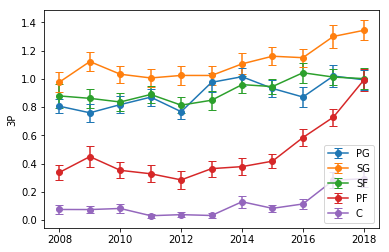

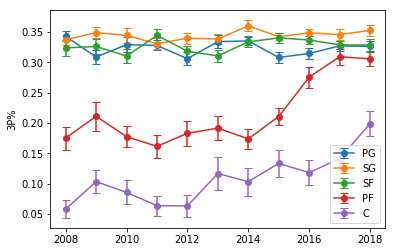

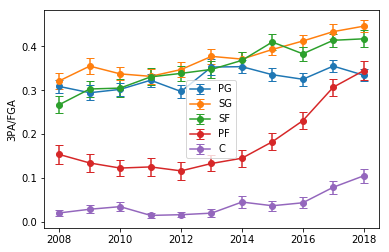

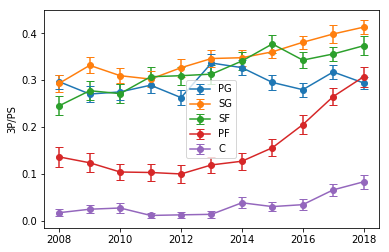

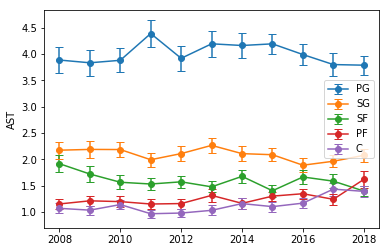

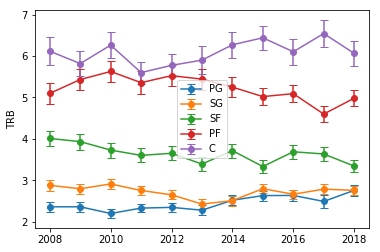

In [19]:
# lets make a plot for any given category and just show it change across years
stats_plot_across_years = ['3P', '3P%', '3PA/FGA', '3P/PS', 'AST', 'TRB']
for curr_stat in stats_plot_across_years:
    pos_list = ['PG', 'SG', 'SF', 'PF', 'C']
    for curr_pos in pos_list:
        curr_mean = []
        curr_sem = []
        for curr_year in years_to_grab:
            idx = (Yearly_df[str(curr_year)]['Pos'] == curr_pos) & (Yearly_df[str(curr_year)]['MP'] > 10)
            curr_vec = Yearly_df[str(curr_year)][curr_stat][idx]
            curr_mean.append(np.nanmean(curr_vec))
            curr_sem.append(stats.sem(curr_vec,nan_policy='omit'))
        plt.errorbar(years_to_grab,curr_mean,curr_sem,marker='o',capsize=4)
    plt.legend(pos_list,loc='best')
    plt.ylabel(curr_stat)
    plt.show()


In [505]:
# lets save the dataframe

with open('/Users/rohanramesh/Documents/SportsData/NBA/YearlyBasicData.pickle', 'wb') as handle:
    pickle.dump(Yearly_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/Users/rohanramesh/Documents/SportsData/NBA/YearlyAdvData.pickle', 'wb') as handle:
    pickle.dump(Yearly_df_adv, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/Users/rohanramesh/Documents/SportsData/NBA/Yearly100possData.pickle', 'wb') as handle:
    pickle.dump(Yearly_df_100pos, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/Users/rohanramesh/Documents/SportsData/NBA/YearlyTeamData.pickle', 'wb') as handle:
    pickle.dump(Yearly_df_team, handle, protocol=pickle.HIGHEST_PROTOCOL)